In [9]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [10]:
sin_wave = np.array([math.sin(x) for x in np.arange(200)])

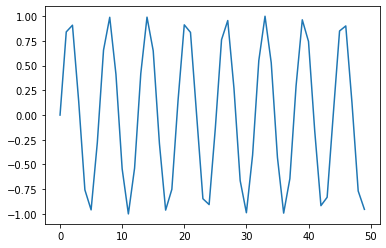

In [11]:
plt.plot(sin_wave[:50])

In [13]:
#create the data
X = []
Y = []

seq_len = 50
num_records = len(sin_wave) - seq_len

for i in range(num_records - 50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])
    
X = np.array(X)
X = np.expand_dims(X, axis=2)

Y = np.array(Y)
Y = np.expand_dims(Y, axis=1)

In [14]:
X.shape, Y.shape

((100, 50, 1), (100, 1))

In [15]:
X_val = []
Y_val = []

for i in range(num_records - 50, num_records):
    X_val.append(sin_wave[i:i+seq_len])
    Y_val.append(sin_wave[i+seq_len])
    
X_val = np.array(X_val)
X_val = np.expand_dims(X_val, axis=2)

Y_val = np.array(Y_val)
Y_val = np.expand_dims(Y_val, axis=1)

In [17]:
#Architechture of RNN model

learning_rate = 0.0001
nepoch = 25
T = 50 #sequence length
hidden_dim = 100
output_dim = 1

bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [18]:
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))

In [19]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

In [23]:
#train the model
#check the loss on training data

for epoch in range(nepoch):
    loss = 0.0
    
    #forward pass
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]
        prev_s = np.zeros((hidden_dim, 1))
        
        for t in range(T):
            new_input = np.zeros(x.shape)
            
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s
        
        #calculate error
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])

In [27]:
#check the loss in validation data

val_loss = 0.0

for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    
    for t in range(T):
        new_input = np.zeros(x.shape)
        new_input[t] = x[t]
        mulu = np.dot(U, new_input)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s
        
    loss_per_record = (y-mulv)**2 / 2
    val_loss += loss_per_record
val_loss = val_loss / float(y.shape[0])

print('Epoch:', epoch + 1, ', Loss:', loss, ', Val Loss:', val_loss)
        

Epoch: 25 , Loss: [[327565.57907157]] , Val Loss: [[65512.31013441]]


In [29]:
#start actual training

for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    
    layers = []
    prev_s = np.zeros((hidden_dim, 1))
    dU = np.zeros(U.shape)
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)
    
    dU_t = np.zeros(U.shape)
    dV_t = np.shape(V.shape)
    dW_t = np.zeros(W.shape)
    
    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)
    
    #forward pass
    
    for t in range(T):
        new_input = np.zeros(x.shape)
        new_input[t]= x[t]
        mulu = np.dot(U, new_input)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        layers.append({'s':s, 'prev_s':prev_s})
        prev_s = s

In [30]:
#backpropogate error
#derivative of pred
dmulv = (mulv - y)

#backward pass
for t in range(T):
    dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
    dsv = np.dot(np.transpose(V), dmulv)
    
    ds = dsv
    dadd = add * (1-add) * ds
    
    dmulw = dadd * np.ones_like(mulw)
    
    dprev_s = np.dot(np.transpose(W), dmulw)
    
    for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
        ds = dsv + dprev_s
        dadd = add * (1 - add) * ds
        
        dmulw = dadd * np.ones_like(mulw)
        dmulu = dadd * np.ones_like(mulu)
        
        dW_i = np.dot(W, layers[t]['prev_s'])
        dprev_s = np.dot(np.transpose(W), dmulw)
        
        new_input = np.zeros(x.shape)
        new_input[t] = x[t]
        dU_i = np.dot(U, new_input)
        dx = np.dot(np.transpose(U), dmulu)
        
        dU_t += dU_i
        dW_t += dW_i
        
    dV += dV_t
    dU += dU_t
    dW += dW_t

In [33]:
#update weights
if dU.max() > max_clip_value:
    dU[dU > max_clip_value] = max_clip_value
if dV.max() > max_clip_value:
    dV[dV > max_clip_value] = max_clip_value
if dW.max() > max_clip_value:
    dW[dW > max_clip_value] = max_clip_value


if dU.min() < min_clip_value:
    dU[dU < min_clip_value] = min_clip_value
if dV.min() < min_clip_value:
    dV[dV < min_clip_value] = min_clip_value
if dW.min() < min_clip_value:
    dW[dW < min_clip_value] = min_clip_value

    
#update  
U -= learning_rate * dU
V -= learning_rate * dV
W -= learning_rate * dW

In [34]:
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

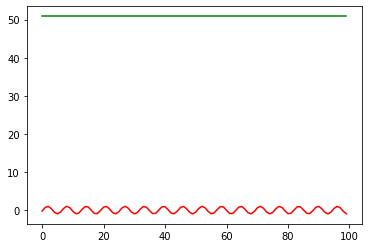

In [35]:
#plotting the output
plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y[:, 0], 'r')
plt.show()

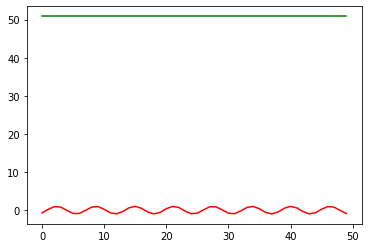

In [36]:
preds = []
for i in range(Y_val.shape[0]):
    x, y = X_val[i], Y_val[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_val[:, 0], 'r')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

math.sqrt(mean_squared_error(Y_val[:, 0] * max_val, preds[:, 0, 0] * max_val))